In [ ]:
!pip install stop-words
!pip install language-detector
!pip install symspellpy
!pip install spacy-langdetect

  Created wheel for language-detector: filename=language_detector-5.0.2-py3-none-any.whl size=7053 sha256=6efa55983cbde124fc5489b3a72477aa31feacf698f1d798ed6bf776173f9f84
  Stored in directory: /root/.cache/pip/wheels/12/40/73/a0765d65e793332b79dfe6c34c713e7c0066ea785191b3f50a
Successfully built language-detector
     |████████████████████████████████| 2.6 MB 887 kB/s eta 0:00:01
     |████████████████████████████████| 998 kB 858 kB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993430 sha256=453134f344880decb121163577917425957a40e0bd3148a0785d3639f639b289
  Stored in directory: /root/.cache/pip/wheels/89/79/3b/9885ae7f4308f73c514f96d8574d40d7d8173a27731b674013
Successfully built langdetect


In [ ]:
!pip install chart_studio
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim.models import Phrases
import collections
import spacy
import wordcloud
import plotly
import re
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.offline import iplot
import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import pandas as pd
from nltk.tokenize import ToktokTokenizer, word_tokenize
import seaborn as sns
from stop_words import get_stop_words
from language_detector import detect_language

import pkg_resources
%matplotlib inline

# Word Cloud
from wordcloud import WordCloud

# sklearn 
from sklearn.feature_extraction.text import CountVectorizer

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

     |████████████████████████████████| 64 kB 642 kB/s eta 0:00:01
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('../input/metadata/metadata.csv', usecols=['cord_uid','source_x','title','license','publish_time',
                           'abstract','authors','journal','url'])
data.head()

,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url
0,ug7v899j,PMC,Clinical features of culture-proven Mycoplasma...,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...
1,02tnwd4m,PMC,Nitric oxide: a pro-inflammatory mediator in l...,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
2,ejv2xln0,PMC,Surfactant protein-D and pulmonary host defense,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
3,2b73a28n,PMC,Role of endothelin-1 in lung disease,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
4,9785vg6d,PMC,Gene expression in epithelial cells in respons...,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...


In [ ]:
data["publish_time"] = pd.to_datetime(data["publish_time"])
data["publish_year"] = (pd.DatetimeIndex(data['publish_time']).year)
data["publish_month"] = (pd.DatetimeIndex(data['publish_time']).month)
data = data[data["publish_year"] >= 2020]
print(data.shape[0], " papers are available within 2020 till 2021.")

672669  papers are available within 2020 till 2021.


In [ ]:
count = 0
index = []
for i in range(len(data)):
    #print(i)
    if type(data.iloc[i, 4])== float:
        count += 1
    else:
        index.append(i)

print(len(index), " papers have abstract available.")

488721  papers have abstract available.


In [ ]:
##extract the abstract to pandas 
documents = data.iloc[index, [2,4]]
documents=documents.reset_index()
documents.drop("index", inplace = True, axis = 1)

##create pandas data frame with all abstracts, use as input corpus
documents["index"] = documents.index.values
documents.head(15)

,title,abstract,index
0,Dexmedetomidine improved renal function in pat...,BACKGROUND: Dexmedetomidine has been reported ...,0
1,Aortic volume determines global end-diastolic ...,BACKGROUND: Global end-diastolic volume (GEDV)...,1
2,Whole genome sequencing and phylogenetic analy...,BACKGROUND: Human metapneumovirus (HMPV) is an...,2
3,European intensive care physicians’ experience...,BACKGROUND: Antimicrobial resistance (AMR) com...,3
4,Synthetic carbohydrate-based vaccines: challen...,Glycoconjugate vaccines based on bacterial cap...,4
5,Acute kidney injury in burn patients admitted ...,BACKGROUND: Acute kidney injury (AKI) is a com...,5
6,Identification of antigens presented by MHC fo...,Mycobacterium tuberculosis (M.tb) is responsib...,6
7,Imaging of tumour response to immunotherapy,A wide range of cancer immunotherapy approache...,7
8,Quantifying the relative impact of contact het...,BACKGROUND: An efficient surface cleaning stra...,8
9,"Paediatric nurses’ general self-efficacy, perc...",BACKGROUND: General self-efficacy is considere...,9


In [ ]:
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
from language_detector import detect_language

import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


def f_base(s):
    # s = string to be processed
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def f_lan(s):
    # boolean to check whether string is english or not
    return detect_language(s) in {'English', 'French','Spanish','Chinese'}

def f_punct(w_list):
    # filtering punctutations and numbers
    return [word for word in w_list if word.isalpha()]

def f_noun(w_list):
    # return word list with noun only
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']

# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    #|set(get_stop_words('cy'))
    |set(get_stop_words('pt'))
    #|set(get_stop_words('tl'))
    |set(get_stop_words('pl'))
    #|set(get_stop_words('et'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    #|set(get_stop_words('so'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    #|set(get_stop_words('cs'))
    |set(get_stop_words('nl'))
    #|set(get_stop_words('sl'))
    #|set(get_stop_words('no'))
    #|set(get_stop_words('zh-cn'))
))

def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]


def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s


def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
#from Autoencoder import *
#from preprocess import *
from datetime import datetime

def preprocess(title, docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    titles = []
    #     samp = list(range(100))
    samp = np.random.choice(n_docs, samp_size)
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
            titles.append(title[idx])
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return titles, sentences, token_lists, idx_in

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
data = documents
data = data.fillna('')
rws = data.abstract
title_entry = data.title
titles, sentences, token_lists, idx_in = preprocess(title_entry, rws, samp_size=51000)

Preprocessing raw texts ...
Preprocessing raw texts. Done!


In [ ]:
df_token = pd.DataFrame({
    'title':titles,
    'abstract':sentences,
    'tokens':token_lists
})
df_token.head()

,title,abstract,tokens
0,Surgical Performance Is Not Negatively Impacte...,". background: during the covid-19 pandemic, s...","[background, shortag, suppli, equip, idea, mas..."
1,Indications for Inpatient Magnetoencephalograp...,magnetoencephalography. is recognized as a va...,"[method, local, zone, area, part, evalu, patie..."
2,Information about COVID-19 for deaf people: an...,objective: to analyze you. tube videos with in...,"[video, inform, sign, languag, studi, video, p..."
3,The Association Between Health Status and Inso...,objectives: this study examined the mediation ...,"[object, studi, mediat, role, fear, associ, he..."
4,Therapeutic targeting of interleukin-6 for the...,"coronavirus disease 19. , caused by infection ...","[diseas, infect, respiratori, syndrom, china, ..."


In [ ]:
df_token.shape

(50600, 3)

Text(0.5, 1.0, 'Word Cloud: Articles About Covid-19')

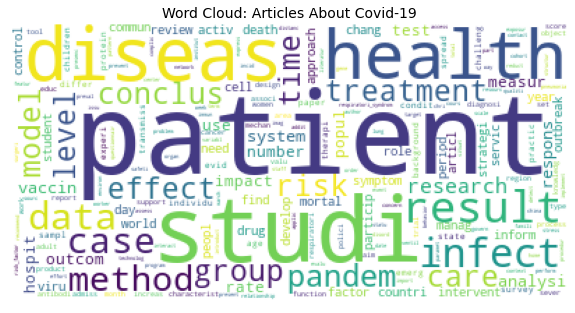

In [ ]:
from gensim.models import Phrases
from wordcloud import WordCloud
import collections
bigram = Phrases(list(df_token['tokens']))
df_token['phrase-tokens'] = df_token['tokens'].apply(lambda x: bigram[x])

abstract_tokens = []
for tokens in list(df_token['phrase-tokens']):
    abstract_tokens += tokens
wordcnt_dict = collections.Counter(abstract_tokens)

wcloud = WordCloud(background_color='white')
wcloud.generate_from_frequencies(wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles About Covid-19' ,fontsize=14)

In [ ]:
df_token.to_csv('tokenized.csv',index=False)